In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

import json

import torch
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision.transforms.functional import InterpolationMode

import random

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

from tqdm.auto import tqdm

In [2]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer

# load models

In [3]:
model_path = '/input/models/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '/input/models/tokenizer/'
text_model_path = '/input/models/text_encoder/'
config_path = './configs/v1-inference.yaml'

In [4]:
tokenizer = CLIPTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(text_model_path, local_files_only=True).cuda().eval()

In [5]:
# pip install omegaconf -i https://pypi.tuna.tsinghua.edu.cn/simple
# pip install accelerate -i https://pypi.tuna.tsinghua.edu.cn/simple

pipe =  StableDiffusionPipeline.from_single_file(
    pretrained_model_link_or_path=model_path,
    config_files={'v1': config_path},
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    local_files_only=True, use_safetensors=True, load_safety_checker=False
).to("cuda")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


# prepare

In [19]:
def get_text_emb(batch):
    
    with torch.no_grad():
        
        batch_encoding = tokenizer(
            batch,
            truncation=True, max_length=77, return_length=True,
            return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
        )
    
        input_ids = batch_encoding["input_ids"].cuda()
        clip_text_opt = text_encoder.text_model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

    return input_ids, clip_text_opt

def get_text_init(batch, n_penultimate_layers=1):

    assert n_penultimate_layers > 0

    input_ids, clip_text_opt = get_text_emb(batch)
    
    penultimate = clip_text_opt.hidden_states[- n_penultimate_layers - 1]
    
    bsz, seq_len = penultimate.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(
        bsz, seq_len, penultimate.dtype, device=penultimate.device
    )

    indices_x = torch.arange(clip_text_opt.last_hidden_state.shape[0], device=clip_text_opt.last_hidden_state.device)
    indices_y = input_ids.to(dtype=torch.int, device=clip_text_opt.last_hidden_state.device).argmax(dim=-1)

    return penultimate, clip_text_opt.pooler_output, causal_attention_mask, indices_x, indices_y

def forward_text(penultimate, causal_attention_mask, indices_x, indices_y):

    last_hidden_state = penultimate
    
    for layer in text_encoder_layers:
        last_hidden_state = layer(
            last_hidden_state, 
            attention_mask=None, 
            causal_attention_mask=causal_attention_mask
        )[0]
    
    last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)

    pooled_output = last_hidden_state[indices_x, indices_y]

    return last_hidden_state, pooled_output

def get_image_data(images: torch.Tensor):
    # Map images to `[0, 1]` space and clip
    images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
    # Transpose to `[batch_size, height, width, channels]` and convert to numpy
    images = images.cpu()
    images = images.permute(0, 2, 3, 1)
    images = images.detach().float().numpy()

    return Image.fromarray((255. * images[0]).astype(np.uint8))

In [15]:
n_penultimate_layers = 2

text_encoder_layers = [text_encoder.text_model.encoder.layers[-i] for i in range(n_penultimate_layers, 0, -1)]

## define scoring model

### use pretrained ranking model

In [41]:
text_scoring_model = torch.nn.Linear(768, 1)
text_scoring_model.load_state_dict(torch.load('./weight/004/environmental/clip_pos_embeds.pt'))
text_scoring_model.eval().cuda();

### use concepts

In [43]:
class ConceptScoringModel(torch.nn.Module):

    def __init__(self, concepts):
        super().__init__()

        _, clip_text_opt = get_text_emb(concepts)

        self.embs = torch.nn.functional.normalize(clip_text_opt.pooler_output, p=2, dim=1).detach()

    def forward(self, x):

        x = torch.nn.functional.normalize(x, p=2, dim=1)

        cosine_similarity_matrix = torch.matmul(x, self.embs.t())

        score = cosine_similarity_matrix.mean(dim=-1, keepdims=True)

        return score

In [69]:
target_concepts = [
    '2d video game',
    'pixel graphic',
    'pixel art',
    'side scrolling platformer level design'
]

text_scoring_model = ConceptScoringModel(target_concepts)

# run

In [70]:
batch = [
    'made of water, featuring holes and a cork stopper, staged warm lighting, game scenes, mink, wearing a hijab, by greg manchess and by craig mullins and by kilian eng and by jake parker, ensure the style is contemporary with clean, a dark grey bird is fighting with a blue bird'
]

In [71]:
init_penultimate, init_pooler_output, causal_attention_mask, indices_x, indices_y = get_text_init(batch, n_penultimate_layers)

In [72]:
score_weight = 1.
similarity_weight = .1

In [76]:
# penultimate = clip_text_opt.hidden_states[-2].detach().clone()
penultimate = init_penultimate.detach().clone()
penultimate.requires_grad = True

optimizer = torch.optim.Adam([penultimate], lr=0.001)

num_iterations = 100

for i in range(num_iterations):
    optimizer.zero_grad()
            
    last_hidden_state, pooler_output = forward_text(penultimate, causal_attention_mask, indices_x, indices_y)
        
    score = text_scoring_model(pooler_output)
    cosine_similarity = torch.cosine_similarity(pooler_output, init_pooler_output.detach())

    loss = - score_weight * score.mean() - similarity_weight * cosine_similarity.mean()
    
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(score.detach().cpu().numpy().flatten(), cosine_similarity.detach().cpu().numpy().flatten())

[0.19067751] [0.9952232]
[0.23397297] [0.9817007]
[0.27496988] [0.9631434]
[0.3145611] [0.9403897]
[0.35341498] [0.9129776]
[0.39189553] [0.8808465]
[0.430168] [0.8445498]
[0.4680732] [0.80423576]
[0.5047841] [0.76012427]
[0.5402408] [0.71409917]


# generate

In [54]:
index = 0

negative_prompt = 'thick thighs and calves. legs or more pairs like shoes on hands, low quality lowres one hand with less than digit, video game, wildcard prompt solo mid shot portrait photo of a whiterun guard from skyrim, mouth and ears should be poorly drawn, six fingers on the hand, wrong proportions, color distortion, poor photography'

seed = random.randint(0, 2 ** 24 - 1)
cfg_strength = 12
image_width = 512
image_height = 512

  0%|          | 0/20 [00:00<?, ?it/s]

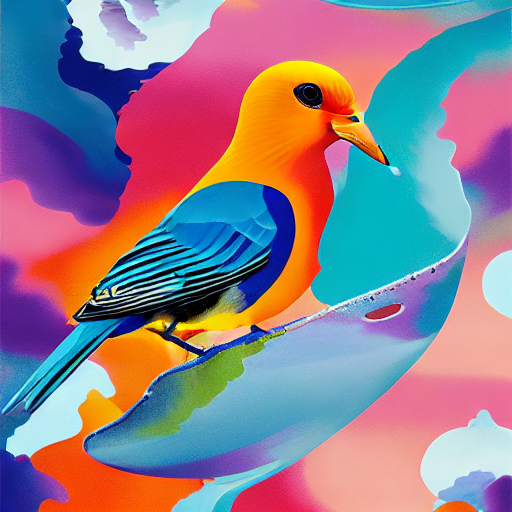

In [80]:
with torch.no_grad():
    image = pipe(
        prompt=batch[index], 
        negative_prompt=negative_prompt, 
        num_inference_steps=20, 
        guidance_scale=cfg_strength,
        generator=torch.Generator(device="cuda").manual_seed(seed)
    )
image.images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

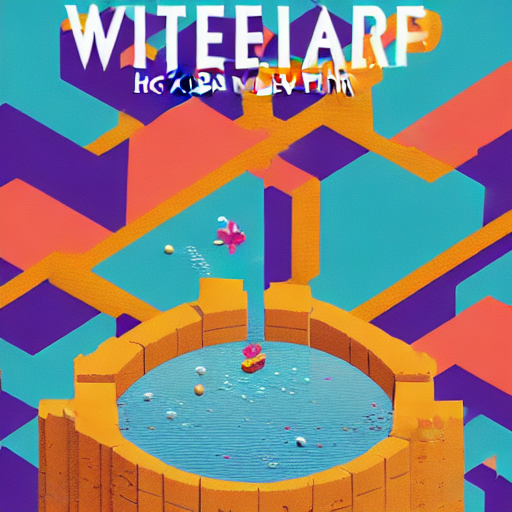

In [81]:
with torch.no_grad():
    image = pipe(
        negative_prompt=negative_prompt, 
        prompt_embeds=last_hidden_state.detach(),
        num_inference_steps=20, 
        guidance_scale=cfg_strength,
        generator=torch.Generator(device="cuda").manual_seed(seed)
    )
image.images[0]